In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=70

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 48772 files belonging to 23 classes.


In [4]:
class_names=dataset.class_names
class_names

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
len(dataset)

1525

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[16 10  4 11  0 18 20  1  4 19 21  6 11 18 20 12 19 17 20 21 15 19  9 21
 10  8  8 18  6 19 21 14]


In [7]:
len(dataset)

1525

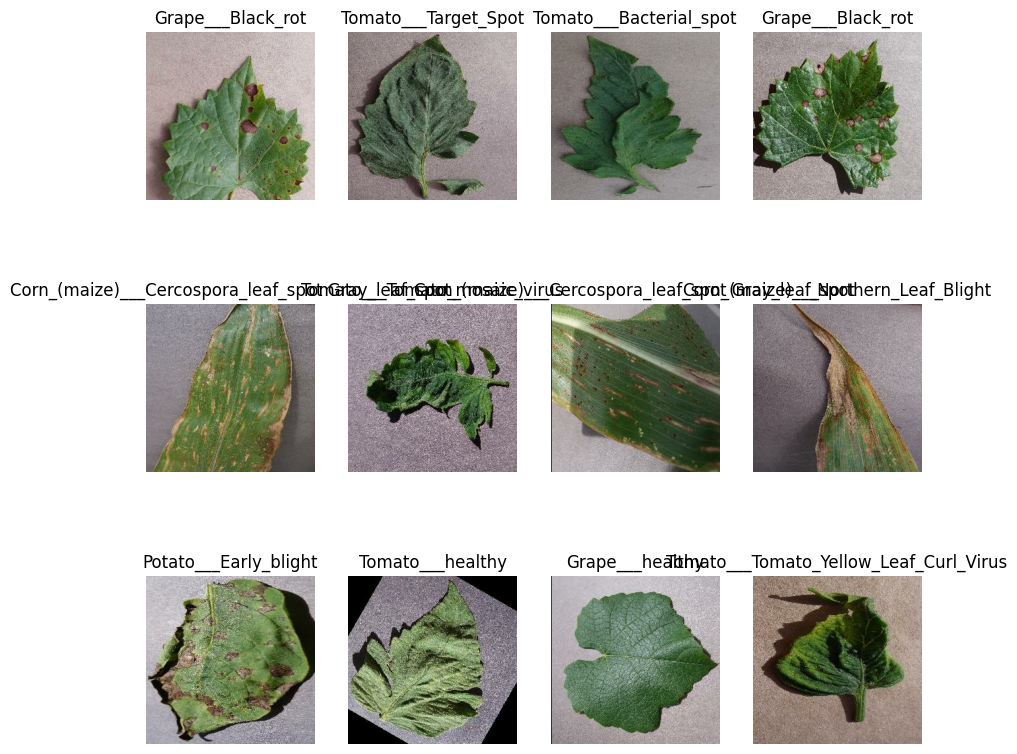

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
80% ==>training
20% ==> 10% validation,10% test

SyntaxError: invalid syntax (3094627512.py, line 1)

In [10]:
train_size=0.8
len(dataset)*train_size

1220.0

In [11]:
train_ds=dataset.take(54)
len(train_ds)

54

In [12]:
test_ds=dataset.skip(54)
len(test_ds)

1471

In [13]:
val_size=0.1
len(dataset)*val_size


152.5

In [14]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds=test_ds.skip(6)
len(test_ds)

1465

In [16]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds =ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
len(train_ds)

1220

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])


In [21]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=23
model=models.Sequential([
     resize_and_rescale,
     data_augmentation,
     layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Flatten(),
     layers.Dense(64,activation='relu'),
     layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)
    


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [25]:
history=model.fit(
train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/70
1220/1220 [==============================] - 384s 226ms/step - loss: 1.6634 - accuracy: 0.4676 - val_loss: 0.8620 - val_accuracy: 0.7078
Epoch 2/70
1220/1220 [==============================] - 281s 230ms/step - loss: 0.6949 - accuracy: 0.7641 - val_loss: 0.9425 - val_accuracy: 0.7074
Epoch 3/70
1220/1220 [==============================] - 286s 234ms/step - loss: 0.4789 - accuracy: 0.8354 - val_loss: 0.6320 - val_accuracy: 0.7889
Epoch 4/70
1220/1220 [==============================] - 277s 227ms/step - loss: 0.3736 - accuracy: 0.8713 - val_loss: 0.4688 - val_accuracy: 0.8413
Epoch 5/70
1220/1220 [==============================] - 282s 231ms/step - loss: 0.3102 - accuracy: 0.8925 - val_loss: 0.4049 - val_accuracy: 0.8647
Epoch 6/70
1220/1220 [==============================] - 281s 230ms/step - loss: 0.2737 - accuracy: 0.9065 - val_loss: 0.2985 - val_accuracy: 0.8960
Epoch 7/70
1220/1220 [==============================] - 273s 224ms/step - loss: 0.2407 - accuracy: 0.9172 - val_

1220/1220 [==============================] - 224s 184ms/step - loss: 0.0820 - accuracy: 0.9731 - val_loss: 0.0986 - val_accuracy: 0.9686
Epoch 57/70
1220/1220 [==============================] - 234s 192ms/step - loss: 0.0790 - accuracy: 0.9741 - val_loss: 0.0840 - val_accuracy: 0.9744
Epoch 58/70
1220/1220 [==============================] - 232s 190ms/step - loss: 0.0817 - accuracy: 0.9731 - val_loss: 0.1477 - val_accuracy: 0.9566
Epoch 59/70
1220/1220 [==============================] - 232s 190ms/step - loss: 0.0799 - accuracy: 0.9737 - val_loss: 0.0811 - val_accuracy: 0.9746
Epoch 60/70
1220/1220 [==============================] - 229s 188ms/step - loss: 0.0812 - accuracy: 0.9748 - val_loss: 0.2811 - val_accuracy: 0.9308
Epoch 61/70
1220/1220 [==============================] - 226s 185ms/step - loss: 0.0832 - accuracy: 0.9728 - val_loss: 0.1479 - val_accuracy: 0.9586
Epoch 62/70
1220/1220 [==============================] - 240s 197ms/step - loss: 0.0878 - accuracy: 0.9711 - val_loss:

In [27]:
scores=model.evaluate(test_ds)


1220/1220 [==============================] - 104s 85ms/step - loss: 0.3586 - accuracy: 0.9069


In [28]:
scores

[0.35855257511138916, 0.9068748354911804]

In [29]:
import numpy as np
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

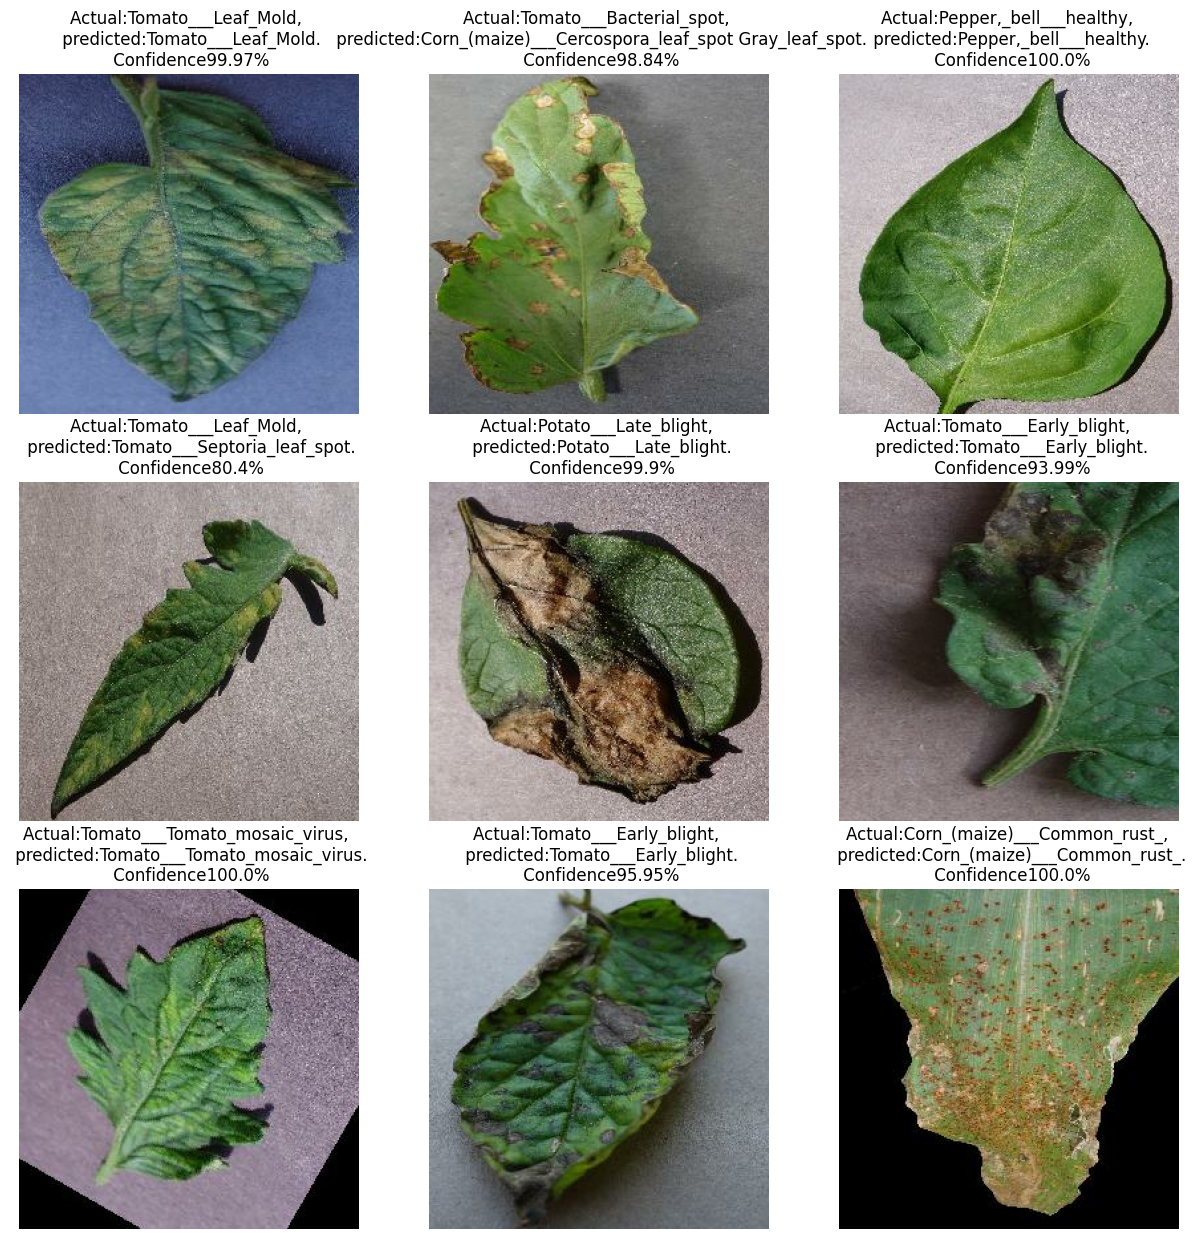

In [30]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class}, \n predicted:{predicted_class}.\n Confidence{confidence}%")
      
        plt.axis("off")

In [33]:
model_version=2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets
